# BOFdat usage example

In [1]:
import cobra
from BOFdat import step1,step2,step3
from BOFdat.util import update
from cobra.util.solver import linear_reaction_coefficients

In [2]:
cobra.Configuration().solver = "cplex"

In [3]:
import optlang
print(optlang.available_solvers)

{'GUROBI': True, 'GLPK': True, 'MOSEK': False, 'CPLEX': True, 'COINOR_CBC': False, 'SCIPY': True, 'OSQP': False, 'HIGHS': False}


## Generating stoichiometric coefficients for the biomass objective function of *E.coli* genome-scale model *i*ML1515

The weight percentage and abundance of each molecule in the cell may vary from an organism to another and vary between growth conditions for a given organism [1,2]. BOFdat allows to incorporate macromolecular cell composition obtained from literature or new experiments to generate new stoichiometric coefficients for your model's biomass objective function (BOF). Once weight percentages are obtained, OMIC data can be incorporated to buff the coefficients and fit to experimental reality. 

### Steps

The following example will lead you through all the necessary steps for the generation of the BOF stoichiometric coefficients (BOFsc) for *E.coli* K12 MG1655 GEM *i*ML1515 [3]. 

1. Obtain the macromolecular composition of the organism

2. Obtain OMICs experimental data

3. Generate BOFsc

4. Generate NGAM and GAM

5. Update BOF (BOFdat!)


#### Sources

[1]  Dennis P. Patrick and Bremmer Hans. (1974) Macromolecular composition during steady-state growth of *Escherichia coli* B/r. Journal of bacteriology


[2] Benjamin Volkmer and Matthias Heinemann. (2011) Condition-Dependent Cell Volume and Concentration of Escherichia coli to Facilitate Data Conversion for Systems Biology Modeling. PLoS One


[3] Jonathan M Monk, Colton J Lloyd, Elizabeth Brunk, Nathan Mih, Anand Sastry, Zachary King, Rikiya Takeuchi, Wataru Nomura, Zhen Zhang, Hirotada Mori, Adam M Feist and Bernhard O Palsson. (2017) *i*ML1515, a knowledgebase that computes Escherichia coli traits. Nat. Biotech.


### 1. Obtain the macromolecular compositon of the organism

*E.coli* has been characterized thoroughly in literature. The BOFsc used in *i*AF1260 [4] are the same in *i*ML1515 [3] and were obtained from Neidhart *et. al* [5].

**Note:** The package also provides the option to include the percentage of each type of RNA molecule in the cell (ribosomal, transfer and messenger). The default values are rRNA: 0.9, tRNA 0.05 and mRNA: 0.05.

#### Sources

[4] Adam M Feist, Christopher S Henry, Jennifer L Reed, Markus Krummenacker, Andrew R Joyce, Peter D Karp, Linda J Broadbelt, Vassily Hatzimanikatis and Bernhard Ø Palsson. (2007) A genome-scale metabolic reconstruction for Escherichia coli K-12 MG1655 that accounts for 1260 ORFs and thermodynamic information. Mol. Syst. Bio. 

[5] Neidhardt FC, Ingraham JL, Schaechter M (1990) Physiology of the Bacterial Cell: a Molecular Approach. Sinauer Associates: Sunderland, Mass

In [3]:
#Set parameters based on dry weight composition
dna_weight_fraction = 0.031
rna_weight_fraction = 0.205
protein_weight_fraction = 0.55
lipid_weight_fraction = 0.1
metabolite_weight_fraction = 0.1

In [4]:
#Give the path to each file as function parameters
#Genome file in BioPython supported format (.faa, .fna) and GenBank file 
#also in BioPython supported format (.gb, .gbff)
genome = '/home/lisa/Dokumente/Programmierung/Scripts/BOFdat-master/docs/data/Ecoli_DNA.fna'
genbank = '/home/lisa/Dokumente/Programmierung/Scripts/BOFdat-master/docs/data/Ecoli_K12_MG1655.gbff'

#OMICs data as a 2 column csv file, gene and abundance
transcriptomic = '/home/lisa/Dokumente/Programmierung/Scripts/BOFdat-master/docs/data/transcriptomic.csv'
proteomic = '/home/lisa/Dokumente/Programmierung/Scripts/BOFdat-master/docs/data/proteomic.csv'

#Lipidomic abundances and conversion to model identifier
lipidomic_abundances = '/home/lisa/Dokumente/Programmierung/Scripts/BOFdat-master/docs/data/lipidomic_abundances.csv'
lipidomic_conversion = '/home/lisa/Dokumente/Programmierung/Scripts/BOFdat-master/docs/data/lipidomic_conversion.csv'

#Metabolomic abundances and conversion to model identifier
metabolomic_abundances = '/home/lisa/Dokumente/Programmierung/Scripts/BOFdat-master/docs/data/metabolomic_abundances.csv'
metabolomic_conversion = '/home/lisa/Dokumente/Programmierung/Scripts/BOFdat-master/docs/data/metabolomic_conversion.csv'

#Growth data on different carbon sources, uptake and secretion rates
maintenance = '/home/lisa/Dokumente/Programmierung/Scripts/BOFdat-master/docs/data/maintenance.csv'

#The model for which the coefficients are generated
model = '/home/lisa/Dokumente/Programmierung/Scripts/BOFdat-master/docs/data/iML1515.json'

### 2. Obtain OMICs experimental data

Your genome should have a GenBank annotated file. This file should be provided in a BioPython supported format (.gb, .gbff). 

Search in literature allowed to find multiple OMICs dataset for different macromolecules that can be used to generate stoichiometric coefficients [6,7,8]. The data should be converted into a 2 column csv file. 
The genome file should be provided in a standard BioPython supported format (.faa or .fna) and is used to calculate the abundance of each base in the genome.

Transcriptomic and proteomic files are 2 column csv files where the first column is the **gene identifier ** and the second column is the relative abundance of each of these genes in the cell. 

Unlike DNA, RNA and proteins that are standard amongst every known life form, the lipid and metabolites in different organisms may vary. Hence a conversion file is required. This first column of this file is the original name of the compound and the second is the target identifier that this compound should have in your model. The first column of the abundance file gives the compound identifier in the model and the second column gives the abundance of that compound in the OMIC dataset.

#### Sources

[6] Sang Woo Seo, Donghyuk Kim, Haythem Latif, Edward J. O’Brien, Richard Szubin & Bernhard O. Palsson. (2014) Deciphering Fur transcriptional regulatory network highlights its complex role beyond iron metabolism in Escherichia coli. Nat. Comm. 


[7] Alexander Schmidt, Karl Kochanowski, Silke Vedelaar, Erik Ahrné, Benjamin Volkmer, Luciano Callipo, Kèvin Knoops, Manuel Bauer, Ruedi Aebersold and Matthias Heinemann. (2016) The quantitative and condition-dependent *Escherichia coli* proteome. Nat. Biotech. 


[8] Kian-Kai Cheng, Baek-Seok Lee, Takeshi Masuda, Takuro Ito, Kazutaka Ikeda, Akiyoshi Hirayama, Lingli Deng, Jiyang Dong, Kazuyuki Shimizu, Tomoyoshi Soga, Masaru Tomita, Bernhard O. Palsson and Martin Robert. (2014) Global metabolic network reorganization by adaptive mutations allows fast growth of Escherichia coli on glycerol. Nat Comm.

### 3. STEP 1: Generate BOFsc for macromolecules and generate maintenance costs

BOFdat operates with a single get_coefficient function for each macromolecule used. Input the parameters determined above as function parameters. Each function outputs a dictionary of metabolite and stoichiometric coefficients. The dictionary can be used to update the BOF (Step 5).

In [5]:
dna_coefficients = step1.generate_dna_coefficients(genome,model,DNA_WEIGHT_FRACTION=dna_weight_fraction)
dna_coefficients

{<Metabolite datp_c at 0x7cfe499f6bf0>: -0.012215685700339098,
 <Metabolite dttp_c at 0x7cfe499f5120>: -0.012578844449428759,
 <Metabolite dctp_c at 0x7cfe499f62f0>: -0.013659391084477245,
 <Metabolite dgtp_c at 0x7cfe49881900>: -0.011993613617708867,
 <Metabolite ppi_c at 0x7cfe49824280>: 0.05044753485195397}

In [6]:
rna_coefficients = step1.generate_rna_coefficients(genbank,model,transcriptomic,RNA_WEIGHT_FRACTION=rna_weight_fraction)
rna_coefficients

/home/lisa/miniconda3/envs/MA/lib/python3.10/site-packages/Bio/SeqFeature.py:230: BiopythonDeprecationWarning: Please use .location.strand rather than .strand
  warnings.warn(


imported file      identifiers   abundances
0          b0001   176.461717
1          b0002  2146.333525
2          b0003  1416.350529
3          b0004  1617.026485
4          b0005    77.042191
...          ...          ...
4327     b4696_2     7.666619
4328       b4697     0.000000
4329       b4702     5.677816
4330       b4703     0.000000
4331       b4705    48.918799

[4332 rows x 2 columns]
merged dataframes       locus                                           sequence         A  \
0     b0001  AUGAAACGCAUUAGCACCACCAUUACCACCACCAUCACCAUUACCA...  0.318182   
1     b0002  AUGCGAGUGUUGAAGUUCGGCGGUACAUCAGUGGCAAAUGCAGAAC...  0.224523   
2     b0003  AUGGUUAAAGUUUAUGCCCCGGCUUCCAGUGCCAAUAUGAGCGUCG...  0.209003   
3     b0004  AUGAAACUCUACAAUCUGAAAGAUCACAACGAGCAGGUCAGCUUUG...  0.236985   
4     b0005  GUGAAAAAGAUGCAAUCUAUCGUACUCGCACUUUCCCUGGUUCUGG...  0.259259   
...     ...                                                ...       ...   
4212  b4399  AUGCGUAUCGGCAUGCGGUUGUUGCUGGGCUAUUUUUU

/home/lisa/miniconda3/envs/MA/lib/python3.10/site-packages/BOFdat/core/rna.py:60: UserWarning: Some identifiers not found in provided annotation
  warnings.warn('Some identifiers not found in provided annotation')


{<Metabolite atp_c at 0x7cfe49baf640>: -0.1556843351415502,
 <Metabolite utp_c at 0x7cfe49bc9a20>: -0.15379576979105725,
 <Metabolite ctp_c at 0x7cfe49ba38e0>: -0.1671601704512458,
 <Metabolite gtp_c at 0x7cfe496760b0>: -0.16306640467110822,
 <Metabolite ppi_c at 0x7cfe49bcb4f0>: 0.6397066800549615}

In [7]:
protein_coefficients = step1.generate_protein_coefficients(genbank,model,proteomic,PROTEIN_WEIGHT_FRACTION=protein_weight_fraction)
protein_coefficients

/home/lisa/miniconda3/envs/MA/lib/python3.10/site-packages/BOFdat/core/protein.py:65: UserWarning: Redundancy in dataset identifiers
  warnings.warn('Redundancy in dataset identifiers')


{<Metabolite ala__L_c at 0x7cfe45d0d270>: -0.7866865810122878,
 <Metabolite cys__L_c at 0x7cfe471498a0>: -0.03986681905592248,
 <Metabolite asp__L_c at 0x7cfe47f33190>: -0.286019444825156,
 <Metabolite glu__L_c at 0x7cfe47f77cd0>: -0.3088742159475492,
 <Metabolite phe__L_c at 0x7cfe45d0d3c0>: -0.12592356497070842,
 <Metabolite gly_c at 0x7cfe45d0d9f0>: -0.8068327457540323,
 <Metabolite his__L_c at 0x7cfe449833a0>: -0.07909538580101926,
 <Metabolite ile__L_c at 0x7cfe47f77880>: -0.29079646817520033,
 <Metabolite lys__L_c at 0x7cfe4714a6e0>: -0.2743566703314616,
 <Metabolite leu__L_c at 0x7cfe44982230>: -0.41251515857770904,
 <Metabolite met__L_c at 0x7cfe47f32350>: -0.10723969052764211,
 <Metabolite asn__L_c at 0x7cfe449821a0>: -0.18757538475910354,
 <Metabolite pro__L_c at 0x7cfe44981720>: -0.22635269540826172,
 <Metabolite gln__L_c at 0x7cfe47f775b0>: -0.16176662571366865,
 <Metabolite arg__L_c at 0x7cfe47f32110>: -0.18048710436993537,
 <Metabolite ser__L_c at 0x7cfe47f47e20>: -0.3038

In [8]:
lipid_coefficients = step1.generate_lipid_coefficients(lipidomic_abundances,lipidomic_conversion,model,LIPID_WEIGHT_FRACTION=lipid_weight_fraction)
lipid_coefficients

/home/lisa/miniconda3/envs/MA/lib/python3.10/site-packages/BOFdat/core/lipid.py:77: UserWarning: Redundancy in dataset identifiers
  warnings.warn('Redundancy in dataset identifiers')


{<Metabolite pe160_p at 0x7cfe449c8b80>: -0.05984233670391253,
 <Metabolite pe161_p at 0x7cfe4716ec80>: -0.030710743257354293,
 <Metabolite pe181_p at 0x7cfe449c9c60>: -0.013250952451946145,
 <Metabolite pg160_p at 0x7cfe449ca2f0>: -0.014826578855136979,
 <Metabolite pg161_p at 0x7cfe4716d180>: -0.013732749319021109,
 <Metabolite pg181_p at 0x7cfe449d16c0>: -0.009098089940190764}

### 4. Generate GAM and NGAM

Growth-associated maintenance (GAM) is the ATP cost related to growth. This includes the polymerization cost of each macromolecule. This cost is unaccounted for in the BOF because the model synthesizes the building blocks of each macromolecule in sufficient quantity to reflect the cell composition but not the cost of assembling those building blocks together. The GAM can be calculated experimentally by growing the bacteria on different sources of carbon at different starting concentrations. The carbon source should be the sole source of carbon in the media and its concentration should be measured after a given time. These remaining concentrations along with the excretion products are used by the package to constrain the model and calculate the ATP cost of growth. 

The file format is shown in the image below:




The carbon sources are in the first column. The second column entails 
Non growth-associated maintenance (NGAM) is the ATP cost of sustaining life without providing and 

/home/lisa/miniconda3/envs/MA/lib/python3.10/site-packages/cobra/util/solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


m 89.08201514974198 b 12.64397680158299
R2= 0.6714793285124079


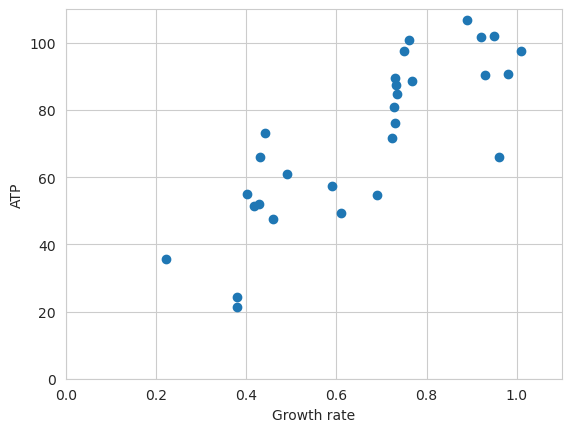

In [9]:
maintenance_cost = step1.generate_maintenance_costs(maintenance,model)

In [10]:
json_model = cobra.io.load_json_model(model)
json_model.solver = "cplex"
update.make_new_BOF(json_model,
                    dna_coefficients,
                    rna_coefficients,
                    protein_coefficients,
                    lipid_coefficients,maintenance=maintenance_cost)

In [11]:
#Model now has a step1 biomass
json_model.slim_optimize()

1.0140756060491174

### 5- Update BOF (BOFdat!)

All the dictionaries have been generated. Now it would be fun to start playing with the model. Actually BOFdat allows you to use the generated dictionaries to update and buff your BOF experimental data. Just buff that!

In [6]:
#Let's load the model we want to update
ecoli = cobra.io.load_json_model(model)

In [7]:
#Let's see what the BOF looks like for E.coli iML1515
from cobra.util.solver import linear_reaction_coefficients
biomass = linear_reaction_coefficients(ecoli).keys()[0]

In [11]:
model_metab_id = [m.id[:-2] for m in ecoli.metabolites]
model_metab_id

[u'2pg',
 u'13dpg',
 u'prbamp',
 u'grdp',
 u'dms',
 u'fpram',
 u'dcyt',
 u'fum',
 u'tyr__L',
 u'feenter',
 u'gg4abut',
 u'arbtn',
 u'aso3',
 u'cpgn_un',
 u'alaala',
 u'3ohexACP',
 u'3ocddec5eACP',
 u'clpn120',
 u'apg141',
 u'dca',
 u'dkdglcn',
 u'chtbs',
 u'fusa',
 u'metglcur',
 u'pep',
 u'h',
 u'rib__D',
 u'2dr1p',
 u'gthrd',
 u'ala__L',
 u'actACP',
 u'actp',
 u'2pglyc',
 u'g3pc',
 u'dmbzid',
 u'xtp',
 u'cd2',
 u'tcynt',
 u'acanth',
 u'so2',
 u'mn2',
 u'pa181',
 u'2agpg181',
 u'tdecoa',
 u'thym',
 u'mocogdp',
 u'octapb',
 u'cysi__L',
 u'dhap',
 u'prbatp',
 u'10fthf',
 u'btal',
 u'6pgg',
 u'co2',
 u'akg',
 u'gsn',
 u'pydx5p',
 u'3dhgulnp',
 u'g3ps',
 u'adphep_LD',
 u'lyx__L',
 u'din',
 u'malt',
 u'pppn',
 u'hphhlipa',
 u'phphhlipa',
 u'murein3px4p',
 u'1odec11eg3p',
 u'12dgr181',
 u'dsbdrd',
 u'sla',
 u'ribflv',
 u'cysi__L',
 u'f1p',
 u'thr__L',
 u'2ddglcn',
 u'btn',
 u'ocdcea',
 u'dtdp4d6dg',
 u'acmum',
 u'man',
 u'adocbl',
 u'frulysp',
 u'dump',
 u'eca4und',
 u'pa160',
 u'cdpdhdec9eg

In [12]:
bd.dna.update_biomass_coefficients(dna_coefficients,ecoli)
bd.rna.update_biomass_coefficients(rna_coefficients,ecoli)
bd.protein.update_biomass_coefficients(protein_coefficients,ecoli)
bd.lipid.update_biomass_coefficients(lipid_coefficients,ecoli)
bd.metabolite.update_biomass_coefficients(metab_coefficients,ecoli)

{<Metabolite datp_c at 0x7f7d1bf10c10>: -0.015666598798418654}
{<Metabolite dttp_c at 0x7f7d1beec7d0>: -0.015942933529341244}
{<Metabolite dgtp_c at 0x7f7d1bda1550>: -0.0156289555189538}
{<Metabolite dctp_c at 0x7f7d1befdfd0>: -0.017017910567671587}
{<Metabolite atp_c at 0x7f7d1a717690>: -0.10057552625516057}
{<Metabolite gtp_c at 0x7f7d1ac66a90>: -0.10975542021927623}
{<Metabolite utp_c at 0x7f7d1a9646d0>: -0.096724121650256692}
{<Metabolite ctp_c at 0x7f7d1a5cb3d0>: -0.10639814736812817}
{<Metabolite val__L_c at 0x7f7d167e7c10>: -0.37820961607292847}
{<Metabolite ser__L_c at 0x7f7d169d6fd0>: -0.2517448481456931}
{<Metabolite ile__L_c at 0x7f7d168c3650>: -0.25085850081740013}
{<Metabolite trp__L_c at 0x7f7d1690c110>: -0.02276363689355101}
{<Metabolite cys__L_c at 0x7f7d16956990>: -0.03393893281661301}
{<Metabolite leu__L_c at 0x7f7d1680b490>: -0.3558603544762082}
{<Metabolite thr__L_c at 0x7f7d169d6290>: -0.259631533661123}
{<Metabolite asp__L_c at 0x7f7d1691f6d0>: -0.2470116812762838

In [13]:
linear_reaction_coefficients(ecoli).keys()[0]

Reaction identifier,Ec_biomass_iML1515_core_75p37M
Name,E. coli biomass objective function (iML1515) - core - with 75.37 GAM estimate
Memory address,0x07f7d14eae190
Stoichiometry,"0.000223 10fthf_c + 2.6e-05 2fe2s_c + 0.000223 2ohph_c + 0.00026 4fe4s_c + 0.627612911971 ala__L_c + 0.000223 amet_c + 0.161929110332 arg__L_c + 0.161998059007 asn__L_c + 0.247011681276 asp__L_c + 0.100575526255 atp_c + 2e-06 btn_c + 0.005205 ca2_c + 0.005205 cl_c + 0.000576 coa_c + 2.5e-05 cobalt2_c + 0.106398147368 ctp_c + 0.000709 cu2_c + 0.0339389328166 cys__L_c + 0.0156665987984 datp_c + 0.0170179105677 dctp_c + 0.015628955519 dgtp_c + 0.0159429335293 dttp_c + 1.51578951944e-05 fad_c + 0.006715 fe2_c + 0.007808 fe3_c + 0.141825601201 gln__L_c + 0.270793150946 glu__L_c + 0.613200453524 gly_c + 0.109755420219 gtp_c + 70.028756 h2o_c + 0.0699114757573 his__L_c + 0.250858500817 ile__L_c + 0.195193 k_c + 0.019456 kdo2lipid4_e + 0.355860354476 leu__L_c + 0.240778115037 lys__L_c + 0.0942919276299 met__L_c + 0.008675 mg2_c + 0.000223 mlthf_c + 0.000691 mn2_c + 7e-06 mobd_c + 0.013894 murein5px4p_p + 0.001831 nad_c + 0.000447 nadp_c + 0.013013 nh4_c + 0.000323 ni2_c + 0.0299979617638 pe160_p + 0.0198372162361 pe161_p + 0.112190529727 phe__L_c + 0.000223 pheme_c + 0.190933683041 pro__L_c + 0.000223 pydx5p_c + 0.000223 ribflv_c + 0.251744848146 ser__L_c + 0.000223 sheme_c + 0.004338 so4_c + 0.000657967131531 succoa_c + 0.000223 thf_c + 0.000223 thmpp_c + 0.259631533661 thr__L_c + 0.0227636368936 trp__L_c + 0.0797282631267 tyr__L_c + 5.5e-05 udcpdp_c + 0.0967241216503 utp_c + 0.378209616073 val__L_c + 0.000341 zn2_c --> 75.37723 adp_c + 75.37723 h_c + 75.37323 pi_c + 0.773903 ppi_c 0.000223 10-Formyltetrahydrofolate + 2.6e-05 [2Fe-2S] iron-sulfur cluster + 0.000223 2-Octaprenyl-6-hydroxyphenol + 0.00026 [4Fe-4S] iron-sulfur cluster + 0.627612911971 L-Alanine + 0.000223 S-Adenosyl-L-methionine + 0.161929110332 L-Arginine + 0.161998059007 L-Asparagine + 0.247011681276 L-Aspartate + 0.100575526255 ATP + 2e-06 Biotin + 0.005205 Calcium + 0.005205 Chloride + 0.000576 Coenzyme A + 2.5e-05 Co2+ + 0.106398147368 CTP + 0.000709 Cu2+ + 0.0339389328166 L-Cysteine + 0.0156665987984 dATP + 0.0170179105677 dCTP + 0.015628955519 dGTP + 0.0159429335293 dTTP + 1.51578951944e-05 Flavin adenine dinucleotide oxidized + 0.006715 Fe2+ + 0.007808 Fe3+ + 0.141825601201 L-Glutamine + 0.270793150946 L-Glutamate + 0.613200453524 Glycine + 0.109755420219 GTP + 70.028756 H2O + 0.0699114757573 L-Histidine + 0.250858500817 L-Isoleucine + 0.195193 potassium + 0.019456 KDO(2)-lipid IV(A) + 0.355860354476 L-Leucine + 0.240778115037 L-Lysine + 0.0942919276299 L-Methionine + 0.008675 magnesium + 0.000223 5,10-Methylenetetrahydrofolate + 0.000691 Mn2+ + 7e-06 Molybdate + 0.013894 two disacharide linked murein units, pentapeptide crosslinked tetrapeptide (A2pm->D-ala) (middle of chain) + 0.001831 Nicotinamide adenine dinucleotide + 0.000447 Nicotinamide adenine dinucleotide phosphate + 0.013013 Ammonium + 0.000323 nickel + 0.0299979617638 phosphatidylethanolamine (dihexadecanoyl, n-C16:0) + 0.0198372162361 phosphatidylethanolamine (dihexadec-9enoyl, n-C16:1) + 0.112190529727 L-Phenylalanine + 0.000223 Protoheme + 0.190933683041 L-Proline + 0.000223 Pyridoxal 5'-phosphate + 0.000223 Riboflavin + 0.251744848146 L-Serine + 0.000223 Siroheme + 0.004338 Sulfate + 0.000657967131531 Succinyl-CoA + 0.000223 5,6,7,8-Tetrahydrofolate + 0.000223 Thiamine diphosphate + 0.259631533661 L-Threonine + 0.0227636368936 L-Tryptophan + 0.0797282631267 L-Tyrosine + 5.5e-05 Undecaprenyl diphosphate + 0.0967241216503 UTP + 0.378209616073 L-Valine + 0.000341 Zinc --> 75.37723 ADP + 75.37723 H+ + 75.37323 Phosphate + 0.773903 Diphosphate"
GPR,
Lower bound,0
Upper bound,1000


# That's it!

Your BOFsc have been updated in your model using BOFdat. 